In [91]:
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

# Build a recommender using PCA tools

### Load data

In [55]:
pca_dimension = 16   # number of coordinates generated previously

In [56]:
engine = sql.create_engine('sqlite:///instacart.db')
db = {}

In [57]:
for table in ['order_products', 'departments', 'aisles']:
    db[table] = pd.read_sql_table(table, engine, index_col=0,)

In [58]:
orders = db['order_products'].groupby('order_id')['product_id'].unique()   # orders = list of products in each order

In [59]:
pca_frame = pd.read_csv('product_pca_coords.csv', index_col=0)
pca_frame.values[:, :pca_dimension] = pca_frame.values[:, :pca_dimension].astype('float')

### Visualize loaded data to make sure it's intact

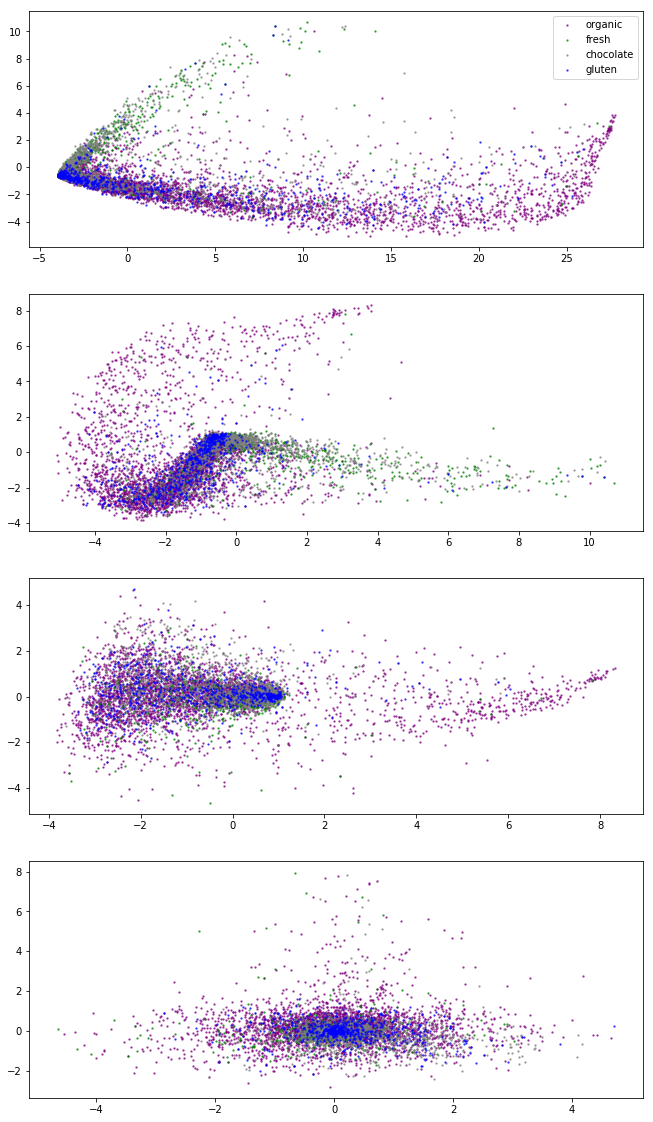

In [125]:
keywords = [
    'organic',
    'fresh',
    'chocolate',
    'gluten',
    ]

colors = [
    'purple',
    'green',
    'gray',
    'blue',
    ]

groups = list(zip(keywords, colors))

num=40000
rows = 4

fig, ax = plt.subplots(nrows=rows)
fig.set_size_inches(11, 20)

for i in range(rows):
    for series, color in groups:
        mask = pca_frame.product_name.str.lower().str.contains(series)
        label = series
        ax[i].scatter(x=pca_frame[mask].values[:, i].reshape(-1), 
                      y=pca_frame[mask].values[:, i+1].reshape(-1),
                      c=color,
                      alpha=.6,
                      s=2,
                      label=label,
                      )
    
ax[0].legend()

### Make some distance functions

In [67]:
def closest_product(product_id, output='scores'):
    try:
        print('best match for:', pca_frame.product_name.loc[product_id])
        my_coords = pca_frame.loc[product_id].values[:pca_dimension].astype('float32')
        actual_index = pca_frame.index.get_loc(product_id)
        # print(actual_index)
    except KeyError:
        print('invalid item')
        return None
    
    diff = pca_frame.values[:, :pca_dimension].astype('float32') - my_coords
    # print(diff.shape, diff.dtype)
    scores = pd.np.linalg.norm(diff, axis=1)
    scores[actual_index] = pd.np.Inf
    # print(scores[:5])

    best = pd.np.argmin(scores)
    if output == 'scores':
        print(pca_frame.product_name.iloc[best])
        return scores
    else:
        return best, pca_frame.product_name.iloc[best], pca_frame.index[best], pd.np.min(scores)

In [79]:
def distance(product_id, target_id):
    try:
        print('distance from:', pca_frame.product_name.loc[product_id], ' to ', pca_frame.product_name.loc[target_id])
        my_coords = pca_frame.loc[product_id].values[:pca_dimension].astype('float32')
        target = pca_frame.loc[target_id].values[:pca_dimension].astype('float32')
        # print(actual_index)
    except KeyError:
        print('invalid item')
        return None
    
    return pd.np.linalg.norm(my_coords - target)

In [69]:
def multi_closest_product(basket):
    point_cloud = pd.np.empty((len(basket), pca_dimension), dtype='float32')
    indices = []
    row = 0
    for product_id in basket:
        try:
            print('best match for:', pca_frame.product_name.loc[product_id])
            coords = pca_frame.loc[product_id].values[:pca_dimension].astype('float32')
            point_cloud[row] = coords
            indices.append(pca_frame.index.get_loc(product_id))
            # print(actual_index)
            row += 1
        except KeyError:
            print('invalid item')
            return None
    
    my_coords = pd.np.mean(point_cloud, axis=0)
    print(my_coords.shape)

    diff = pca_frame.values[:, :pca_dimension].astype('float32') - my_coords
    # print(diff.shape, diff.dtype)
    scores = pd.np.linalg.norm(diff, axis=1)
    for i in indices:
        scores[i] = pd.np.Inf
    # print(scores[:5])

    best = pd.np.argmin(scores)

    return best, pca_frame.product_name.iloc[best], pca_frame.index[best], pd.np.min(scores)

In [71]:
closest_product(1, output=False)

best match for: Chocolate Sandwich Cookies


(26437, 'Veggie Cheese & Pretzel Snack Pac Prepacked', 30633, 1.316407)

In [72]:
multi_closest_product([1, 2])

best match for: Chocolate Sandwich Cookies
best match for: All-Seasons Salt
(16,)


(2100, 'Peppermint Gum', 2458, 1.294741)

# Recommend some stuff!

In [73]:
l = []
for i in pca_frame.index.values[:10]:
    l.append(i)
    print(multi_closest_product(l))
    print()

best match for: Chocolate Sandwich Cookies
(16,)
(26437, 'Veggie Cheese & Pretzel Snack Pac Prepacked', 30633, 1.316407)

best match for: Chocolate Sandwich Cookies
best match for: All-Seasons Salt
(16,)
(2100, 'Peppermint Gum', 2458, 1.294741)

best match for: Chocolate Sandwich Cookies
best match for: All-Seasons Salt
best match for: Robust Golden Unsweetened Oolong Tea
(16,)
(39674, 'Double Chocolate Muffins', 46065, 1.6965892)

best match for: Chocolate Sandwich Cookies
best match for: All-Seasons Salt
best match for: Robust Golden Unsweetened Oolong Tea
best match for: Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce
(16,)
(25659, 'Caffeine Free Diet Coke', 29735, 1.8516276)

best match for: Chocolate Sandwich Cookies
best match for: All-Seasons Salt
best match for: Robust Golden Unsweetened Oolong Tea
best match for: Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce
best match for: Green Chile Anytime Sauce
(16,)
(31644, 'Organic Agave Nectar', 36

In [80]:
def generate_recs(i):
    try:
        basket = orders.iloc[i]
        actual_last = basket[-1]
        basket = basket[:-1]
    except KeyError:
        print('order_id {} may exist in orders.index, but contains no items. \n'.format(orders.index[i]))
        return None
    
    print('\n' + '+ ' * 30 + '\n')
    print(pca_frame.loc[basket].product_name)

    ind, name, product_id, score = multi_closest_product(basket)
    
    print()
    print('we chose:')
    print(name)

    print()
    print('actual final item:')
    print(pca_frame.loc[actual_last].product_name)
    
    print()
    print('distance between items:', distance(product_id, actual_last))
        
    print()

In [81]:
for _ in range(20):
    generate_recs(pd.np.random.randint(0, 10000))


+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 

Series([], Name: product_name, dtype: object)
(16,)

we chose:
Chocolate Sandwich Cookies

actual final item:
Freshly Squeezed Orange Juice

distance from: Chocolate Sandwich Cookies  to  Freshly Squeezed Orange Juice
distance between items: 24.96351


+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 

product_id
47877                                            Coke Zero
19173                 Orange Calcium & Vitamin D Pulp Free
19033    Vaporizing Decongestant Vicks VapoRub Cough Su...
28760                 Soup Secrets Chicken Noodle Soup Mix
24761              Slow Kettle Roasted Chicken Noodle Soup
34898      Low Moisture Part Skim Mozzarella String Cheese
23687                           Multi Grain Sandwich Thins
4986                              Light Butter with Canola
17545                                   Rotisserie Chicken
22619                      Cool Whipe Lite Whipped Topping
Name: product_name, d

/home/sam/.envs/instacart/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sam/.envs/instacart/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/sam/.envs/instacart/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)



we chose:
Original Enriched Rice Drink

actual final item:
Pure Irish Butter

distance from: Original Enriched Rice Drink  to  Pure Irish Butter
distance between items: 10.195543


+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 

product_id
28842                   Bunched Cilantro
28348    Organic Kidney Beans Low Sodium
28954         Classic Rotisserie Chicken
Name: product_name, dtype: object
best match for: Bunched Cilantro
best match for: Organic Kidney Beans Low Sodium
best match for: Classic Rotisserie Chicken
(16,)

we chose:
Pistachio Pistachio Ice Cream

actual final item:
White Onion

distance from: Pistachio Pistachio Ice Cream  to  White Onion
distance between items: 16.630404


+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 

product_id
30391                      Organic Cucumber
24964                        Organic Garlic
15200                   Organic Green Beans
21903                  Organic Baby Spinach
1244             Organic Orange Bell 


we chose:
Chocolate Sandwich Cookies

actual final item:
Pure Irish Butter

distance from: Chocolate Sandwich Cookies  to  Pure Irish Butter
distance between items: 29.250433


+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 

product_id
21137            Organic Strawberries
46979                       Asparagus
41290                        Lemonade
44292    Premium Unsweetened Iced Tea
45                  European Cucumber
26209                           Limes
44275          Mini Blueberry Muffins
Name: product_name, dtype: object
best match for: Organic Strawberries
best match for: Asparagus
best match for: Lemonade
best match for: Premium Unsweetened Iced Tea
best match for: European Cucumber
best match for: Limes
best match for: Mini Blueberry Muffins
(16,)

we chose:
Boomchickapop Sea Salt Popcorn

actual final item:
Original BBQ Sauce

distance from: Boomchickapop Sea Salt Popcorn  to  Original BBQ Sauce
distance between items: 9.459295


+ + + + + + + + + + + + + + 

# Recommender works... ok!

Recommendations are generally reasonable and fall in the space of products that these consumers may purchse.

### Things to improve:

This system only uses our PCA distance metric. It could definitely be improved by using other available data:
0. The way distances are dealt with here is dumb! Average vs. cluster
1. Department/Aisle info
2. Product add-to-order sequence data
3. Time of day/week information
4. (customer purchase history if this was for real deployment)
5. Text from product description
6. Most of product graph was thrown out (for RAM / time / complexity)
7. Internal parameters (# dimensions, 'oddity') have not been tuned

# Ultimately, this system is only measuring fake distances and finding the closest items. It could probably be more nuanced
